**Ficheux et al, arXiv:2011.02634**

In this notebook we want to capture the basic effect behind the two-qubit gate for fluxonia described in the paper by Ficheux et al(2020) "Fast logic with slow qubits:microwave-activated controlled-Z gate on low-frequency fuxoniums"

In [1]:
import numpy as np
import sys
import time
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

from itertools import product, combinations
from IPython.display import display, Latex

%matplotlib notebook
plt.rcParams['figure.figsize'] = (8, 5)

from IPython.display import display, HTML, Image

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%reload_ext jupyternotify

#%notify

<IPython.core.display.Javascript object>

The gate is based on the following driven Hamiltonian of two-capacitively coupled fluxonium qubits

$$\hat{H} = \hat{H}^{(0)}_A + \hat{H}^{(0)}_B + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_A = 4 E_{C,A} \cdot \hat{n}^2_A + \frac{1}{2}E_{L,A}\cdot\hat{\varphi}^2_A - E_{J,A}\cos\left(\hat{\varphi}_A - \phi_{ext,A}\right)$$

$$\hat{H}^{(0)}_B = 4 E_{C,B} \cdot \hat{n}^2_B + \frac{1}{2}E_{L,B}\cdot\hat{\varphi}^2_B - E_{J,B}\cos\left(\hat{\varphi}_B - \phi_{ext,B}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_A \cdot \hat{n}_B$$

$$\frac{\hat{H}_{drive}}{h} = \left( \epsilon_A \hat{n}_A + \epsilon_B \hat{n}_B \right) \cos(2\pi f_d t)$$

# Single fluxonia
We take parameters as in Table 1 of the paper

In [2]:
# Values in GHz (divided by h)
#Fluxonium A
ec_a = .973
el_a = .457
ej_a = 5.899 
flux_a = 1/2

# Fluxonium B 
ec_b = 1.027
el_b = 0.684
ej_b = 5.768
flux_b = 1/2

n_fock = 100

Let us first reproduce the other parameters in Table 1

In [3]:
levels = 5
flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock)
flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock)
flx_a.diagonalize_basis(levels)
flx_b.diagonalize_basis(levels)
# If you run this twice it gives an error, so this has to be fixed in the source code

In [4]:
energies_a, eig_states_a = flx_a.eig_states(levels)
energies_b, eig_states_b = flx_b.eig_states(levels)
for k in range(0, 3):
    print('------')
    print('f_' + str(k) + str(k + 1) + '^A = ' + str(energies_a[k + 1] - energies_a[k]) + ' GHz' )
    print('f_' + str(k) + str(k + 1) + '^B = ' + str(energies_b[k + 1] - energies_b[k]) + ' GHz' )
print('------')

------
f_01^A = 0.06987744707831667 GHz
f_01^B = 0.13833691129686648 GHz
------
f_12^A = 5.185077668515964 GHz
f_12^B = 4.922394350520492 GHz
------
f_23^A = 0.9905236831630644 GHz
f_23^B = 1.5308324694726387 GHz
------


<IPython.core.display.Javascript object>


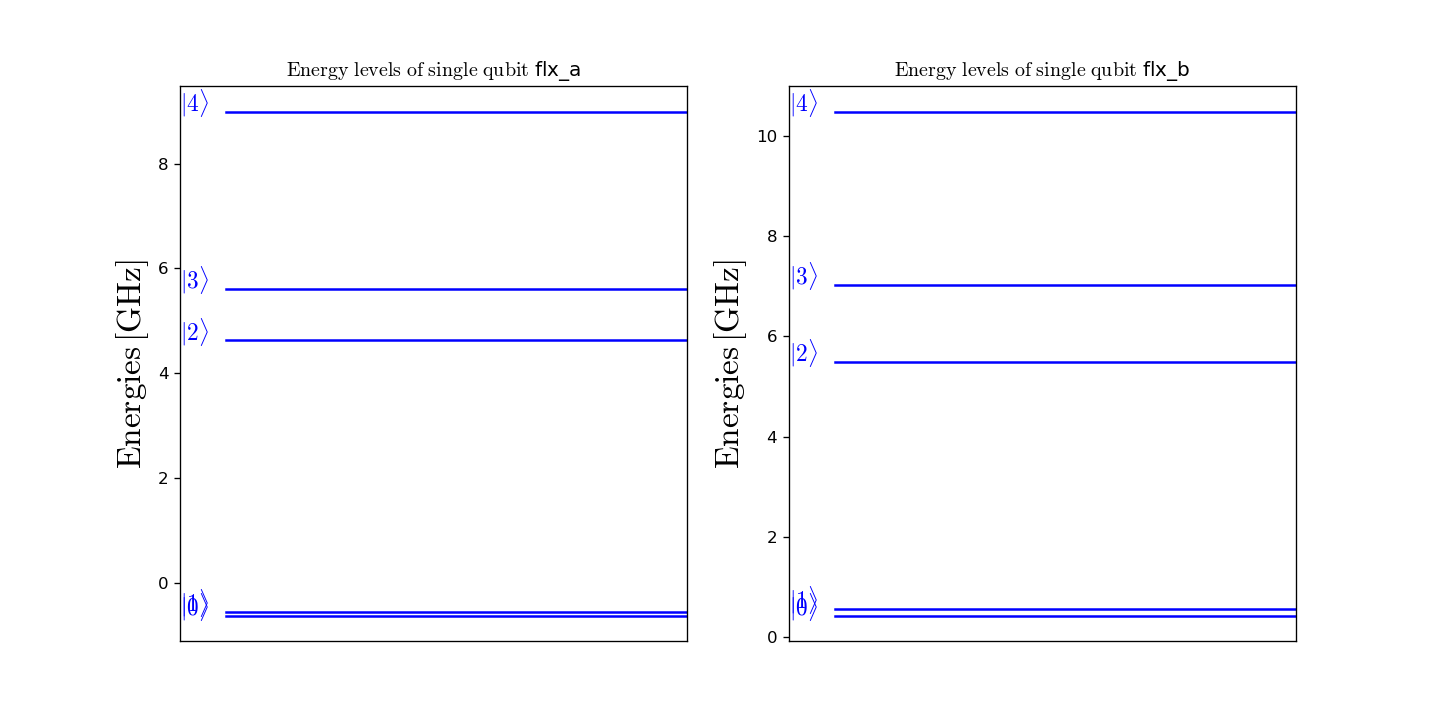

In [5]:
#plot les nvx d'énergie des a et b ide by side

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
text_lab = ["$| " + str(k) + " \\rangle $" for k in range(levels)]

def plot_energies_single(energies, text_lab, opt, name, ax):
    for k in range(0, levels):
        ax.plot([0,1], [energies[k]]*2, color='blue')
        ax.text(-0.1, energies[k], text_lab[k], fontsize=opt['fs_text'], color='blue')

    ax.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
    ax.set_title("$\mathrm{Energy \ levels \ of \ single \ qubit \ }$" + name)
    ax.xaxis.set_visible(False)
    ax.set_xlim(-.1, 1)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_energies_single(energies_a, text_lab, opt, "flx_a",  ax[0])
plot_energies_single(energies_b, text_lab, opt, "flx_b",  ax[1])


Thus, we correctly recover the frequencies Table 1 in the paper. Notice that the eigenenergies are also divided by $h$ and so are intended as frequencies and not as angular velocities;

In [6]:
for k in range(0, 2):
    print('------')
    print('|n_' + str(k) + str(k + 1) + '^A| = ' + \
          str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[k], eig_states_a[k + 1]))))
    print('|n_' + str(k) + str(k + 1) + '^B| = ' + \
          str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[k], eig_states_b[k + 1]))))
print('------')
print('|n_' + str(0) + str(3) + '^A| = '  + \
      str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[0], eig_states_a[3]))))
print('|n_' + str(0) + str(3) + '^B| = '  + \
      str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[0], eig_states_b[3]))))

------
|n_01^A| = 0.0253055781562991
|n_01^B| = 0.044713989127811764
------
|n_12^A| = 0.598101783710907
|n_12^B| = 0.5862083695927306
------
|n_03^A| = 0.585651023426629
|n_03^B| = 0.5522868863936361


We see that $n^{\alpha}_{0-1} \ll n^{\alpha}_{1-2}$ as predicted by Ficheux

<IPython.core.display.Javascript object>


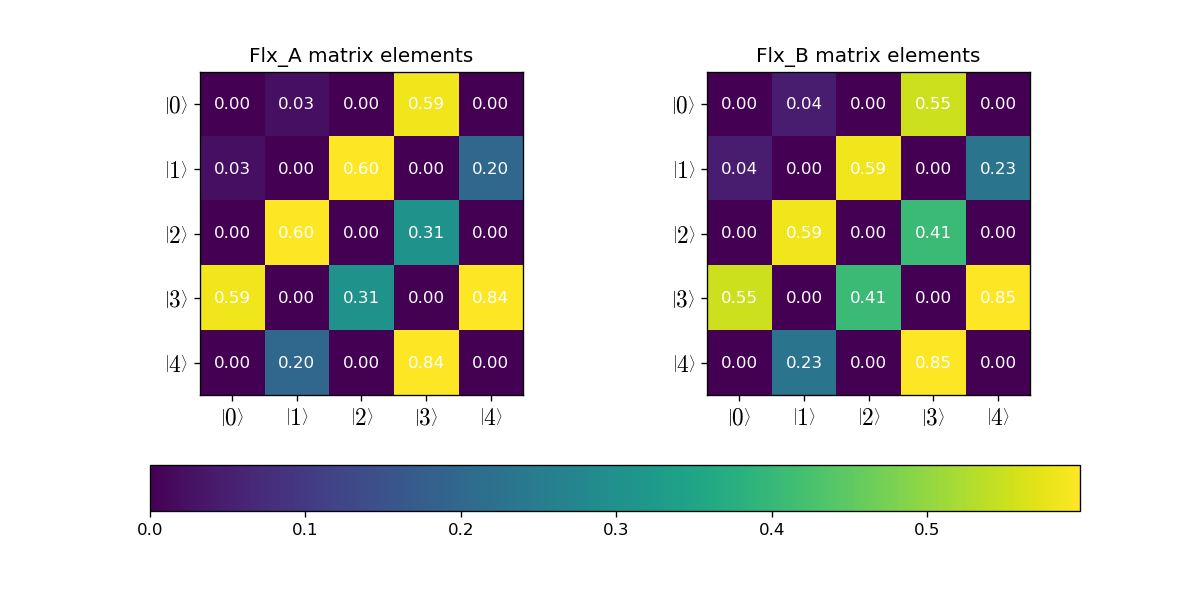

In [7]:
def plot_charge_op(flx, name, ax, vmin, vmax):
    lv = range(levels)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in lv]
    mat_elements = flx.mat_elements(operator='charge_op', levels=lv, as_xarray=True)

    
    im = ax.imshow(np.abs(mat_elements), cmap='viridis', vmin = vmin, vmax = vmax)

    for in_level, out_level in product(lv, repeat=2):
        amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")

    ax.set_xticks(lv)
    ax.set_yticks(lv)
    ax.set_xticklabels(level_labels, fontsize = 14)
    ax.set_yticklabels(level_labels, fontsize = 14)

#     cbar = plt.colorbar()
#     cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{F}_{i \rightarrow f}$", rotation=-90, va="bottom")

    ax.set_title(name +  ' matrix elements')

    return im

vmin = min(np.min(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.min(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

vmax = max(np.max(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.max(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ima = plot_charge_op(flx_a, "Flx_A", ax[0], vmin, vmax)
imb = plot_charge_op(flx_b, "Flx_B", ax[1], vmin, vmax)

fig.colorbar(ima, ax=ax.ravel().tolist(), orientation = 'horizontal')

In [8]:
energies_ab_bare = np.zeros(levels**2, dtype=float)
count = 0
for k in range(0, levels):
    for m in range(0, levels):
        energies_ab_bare[count] = energies_b[m] + energies_a[k]
        count += 1
label_converter = np.argsort(energies_ab_bare)

In [9]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels: int,
    energies: np.ndarray,
    label_converter: np.ndarray
) -> float:
    label = k*levels + m
    index = np.where(label_converter==label)[0][0]
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray
) -> float:
    label = k*levels + m
    index = np.where(label_converter==label)[0][0]
    return eig_states[index] 

# Coupled fluxonia

As a preliminary study, I want to plot the energy levels of the coupled system as a function of the coupling strength $J_C$. I take coupling strengths similar to those taken in the paper (see Fig. 2).

Expected Energy spectrum ($J_c = 224$ MHz) :
![](energy_levels.jpg)

In [ ]:
text_lab = ["$| 00 \\rangle $", "$| 01 \\rangle $", "$| 10 \\rangle $", "$| 11 \\rangle $", \
            "$| 02 \\rangle $", "$| 12 \\rangle $", "$| 20 \\rangle $", "$| 21 \\rangle $"]

text_lab_no_latex = ["|00>", "|01>", "|10>", "|11>", \
                     "|02>", "|12>", "|20>", "|21>" ]

## Role of J_c

In [ ]:
n_points = 20
levels_plot = 8
jc_list = np.linspace(0, 0.4, n_points)
en_mat = np.zeros([levels_plot, n_points], dtype=float)
for k in range(0, n_points):
    coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_list[k])
    en_mat[:, k] = coupled_flx.eig_energies(levels_plot)

In [ ]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_energies_jc(
    en_mat: np.ndarray, 
    jc_list:np.ndarray, 
    opt:dict
) -> None:
    n_lev = en_mat.shape[0]
    text_lab = ["$| 00 \\rangle $", "$| 01 \\rangle $", "$| 10 \\rangle $", "$| 11 \\rangle $", \
                "$| 02 \\rangle $", "$| 12 \\rangle $", "$| 20 \\rangle $", "$| 21 \\rangle $"]
    fig, ax = plt.subplots(figsize=(7, 7))
    for k in range(0, n_lev):
        ax.plot(jc_list, en_mat[k, :], linewidth=opt['lw'], color='black')
        plt.text(-0.03, en_mat[k, 0], text_lab[k], fontsize=opt['fs_text'], color='black')
    ax.axes.set_xlabel("$J_C \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])

    ax.tick_params(axis='both', labelsize=opt['ls'])
    plt.show()
    
plot_energies_jc(en_mat, jc_list, plot_setup) 

## Coupling

In [ ]:
jc = 0#0.224 #GHz (divided by h)

coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_flx.eig_states() 

coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 


for k in range(len(text_lab)):
    print(str(k)+"th energy level " + text_lab_no_latex[k] + " :  Bare : " + str(np.round(energies_bare[k], 4)) + 
          "[GHz] || Interacting : " + str(np.round(energies_sys[k], 4)) + "[GHz]")

In [ ]:
def plot_charge_op(opé, name, xmax, ymax):
    lvx = range(xmax)
    lvy = range(ymax)
    level_labels = ['$ |' + str(  np.argmax(np.abs(level))//levels  ) + \
                                str(  np.argmax(np.abs(level)) %levels  ) + '\\rangle $' for level in eigstates_sys]
    mat_elements = np.zeros((xmax, ymax))
    
    
    plt.figure(figsize = (7, 7))
    for a in range(xmax):
        for b in range(ymax):
            in_level = np.conj(eigstates_sys[a].T)
            out_level = eigstates_sys[b]
            mat_elements[a, b] = np.abs(in_level.dot(opé).dot(out_level))
#             plt.text(a, b, '{:.2f}'.format(float(mat_elements[a, b])), ha="center", va="center", color="white")


    plt.imshow(np.abs(mat_elements), cmap='viridis')            

    plt.xticks(ticks = lvx, labels = level_labels[:xmax], fontsize = 14)
    plt.yticks(ticks = lvy, labels = level_labels[:ymax], fontsize = 14)

    plt.title(name +  ' matrix elements')
    plt.colorbar()
    
    return mat_elements

n_a = tensor_prod([flx_a.charge_op(), np.identity(levels)])
n_b = tensor_prod([np.identity(levels), flx_b.charge_op()])
ope = n_a*n_b

_ = plot_charge_op(ope, "$\hat{n}_A \hat{n}_B$",4, 4)

## Energies and eigenvalues of H

In [ ]:
#Compare levels bare-int

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
text_lab = ["$| 00 \\rangle $", "$| 01 \\rangle $", "$| 10 \\rangle $", "$| 11 \\rangle $", \
            "$| 02 \\rangle $", "$| 12 \\rangle $", "$| 20 \\rangle $", "$| 21 \\rangle $"]

plt.figure(figsize=(7, 7))
for k in range(0, 8):
    plt.plot([0,.99], [energies_bare[k]]*2, color='blue', linestyle = ':', label = "bare")
    plt.text(-0.08, energies_bare[k], text_lab[k], fontsize=opt['fs_text'], color='blue')
    
    plt.plot([1.01, 2], [energies_sys[k]]*2, color='black', label = "coupled")
    plt.text(+2.03, energies_sys[k], text_lab[k], fontsize=opt['fs_text'], color='black')
    
    if k==0:
        plt.legend()
    
plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
plt.tick_params(axis='both', labelsize=opt['ls'])

frame1 = plt.gca()
frame1.axes.xaxis.set_visible(False)



In [ ]:
state00 = qtp.Qobj(inpt=  label_to_states(0, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state01 = qtp.Qobj(inpt=  label_to_states(0, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state10 = qtp.Qobj(inpt=  label_to_states(1, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state11 = qtp.Qobj(inpt=  label_to_states(1, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])

fig, ax = plt.subplots(1, 4, figsize = (7,5))

im0 = ax[0].imshow(np.abs(state00.full()), vmin = 0, vmax = 1)
ax[0].axes.xaxis.set_visible(False)
ax[0].set_title("$\\approx | 00 \\rangle ^{bare}$")

ax[1].imshow(np.abs(state01.full()), vmin = 0, vmax = 1)
ax[1].axes.xaxis.set_visible(False)
ax[1].set_title('$\\approx | 01 \\rangle ^{bare}$')

ax[2].imshow(np.abs(state10.full()), vmin = 0, vmax = 1)
ax[2].axes.xaxis.set_visible(False)
ax[2].set_title('$\\approx | 10 \\rangle ^{bare}$')

ax[3].imshow(np.abs(state11.full()), vmin = 0, vmax = 1)
ax[3].axes.xaxis.set_visible(False)
ax[3].set_title('$\\approx | 11 \\rangle ^{bare}$')

fig.colorbar(im0, ax=ax[:].ravel().tolist(), orientation = 'vertical')

fig = plt.gcf()
fig.suptitle('$\mathrm{Eigenstates \ of \ the \ coupled \ system \ in \ product \ basis}$', fontsize=14)

In [ ]:
fig, ax = plt.subplots(1, 25, figsize = (10,5))
for k in range(levels**2):
    ax[k].imshow(np.abs(np.array([eigstates_sys[k]]).T), vmin = 0, vmax = 1)
    ax[k].axes.xaxis.set_visible(False)
    ax[k].set_title(np.round(energies_sys[k], 2))
    
fig = plt.gcf()
fig.suptitle('$\mathrm{Eigenstates \ of \ the \ coupled \ system \ in \ product  \
             \ basis \ and \ their \ eigen-energy}$', fontsize=12)

# Drive

In [ ]:
big_delta = energies_sys[7] - energies_sys[6] + energies_sys[1] - energies_sys[3]
small_delta_opt = .29*big_delta

freq_drive_opt = energies_sys[7] - energies_sys[3] - small_delta_opt
freq_drive = freq_drive_opt

t_drive = 1/big_delta


We use the conventions of the paper :
$$\Delta = f_{11-21} - f_{10-20}$$
$$\delta = f_{11-21} - f_d$$

According to the paper, the optimal value for $\dfrac{\delta}{\Delta}$ is $\dfrac{\delta}{\Delta} = 0.29 $

With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$

In [ ]:
print("Big Delta = ", big_delta)
print("small delta = ", small_delta_opt)

print('Optimal drive frequency fd: ' + str(freq_drive) + ' [GHz]')

In [ ]:
eta = [1, 0] #should only drive first qubit
n_a = tensor_prod([flx_a.charge_op(), np.identity(levels)])
n_b = tensor_prod([np.identity(levels), flx_b.charge_op()])
n_charge = [n_a, n_b]

In [ ]:
rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
print('Rabi period: ' + str(rabi_period) + ' [ns]')

#  Simulations

We now want to perform simulations. The first task is to reproduce the two-photon Rabi oscillations and show that they reproduce correctly the Rabi period.

In [ ]:
freq_drive = energies_a[1] - energies_a[0]

In [ ]:
#simulation setup (noiseless)
t_points = 2000
tps_simu =   2* 40 *2*np.pi #2*rabi_period*2*np.pi
tlist = np.linspace(0, tps_simu, t_points)

state_in = state00 #state00 + state01 + state10 + state11
rho_in = state_in*state_in.dag()

hamil0 = coupled_flx.hamiltonian(as_qobj=True)
hamil_drive = qtp.Qobj(inpt=eta[0]*n_charge[0] + eta[1]*n_charge[1], 
                       dims=hamil0.dims, shape=hamil0.shape, isherm=True)
pulse_drive = np.cos(freq_drive*tlist)

In [ ]:
# Simulation run
result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

## Probs

In [ ]:
#Def the other states
state02 = qtp.Qobj(inpt=  label_to_states(0, 2, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state12 = qtp.Qobj(inpt=  label_to_states(1, 2, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state20 = qtp.Qobj(inpt=  label_to_states(2, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state21 = qtp.Qobj(inpt=  label_to_states(2, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])

#and the rhos
rho_00 = state00*state00.dag()
rho_01 = state01*state01.dag()
rho_10 = state10*state10.dag()
rho_11 = state11*state11.dag()

rho_02 = state02*state02.dag()
rho_12 = state12*state12.dag()
rho_20 = state20*state20.dag()
rho_21 = state21*state21.dag()

probs = np.zeros([8, t_points], dtype=float)
for k in range(0, t_points):
    probs[0, k] = qtp.expect(rho_00, result.states[k]) 
    probs[1, k] = qtp.expect(rho_01, result.states[k]) 
    probs[2, k] = qtp.expect(rho_10, result.states[k]) 
    probs[3, k] = qtp.expect(rho_11, result.states[k]) 
    probs[4, k] = qtp.expect(rho_02, result.states[k])
    probs[5, k] = qtp.expect(rho_12, result.states[k])
    probs[6, k] = qtp.expect(rho_20, result.states[k])
    probs[7, k] = qtp.expect(rho_21, result.states[k])

In [ ]:
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    fig, ax = plt.subplots(2, 4, figsize = (10, 8))
    for k in range(0, 8):

        ax[k//4, k%4].plot(tlist, probs[k, :])
#         ax[k//levels, k%levels].plot([t_drive, t_drive], [0, 1])

        ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title(text_lab[k])
        
        if k%levels != 0:
            ax[k//4, k%4].axes.yaxis.set_ticklabels([])

        
    fig = plt.gcf()
    fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
                 each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                 $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    
        
plot_probas(tlist/(2*np.pi), probs, plot_setup)
    

## Phases

In [ ]:
#We get the phase of the 'projections' that once squared will give the probabilities
phases = np.zeros([8, t_points], dtype=float)
for k in range(0, t_points):
    phases[0, k] = cmath.phase((result.states[k].dag() * state00).full()[0,0])
    phases[1, k] = cmath.phase((result.states[k].dag() * state01).full()[0,0])
    phases[2, k] = cmath.phase((result.states[k].dag() * state10).full()[0,0])
    phases[3, k] = cmath.phase((result.states[k].dag() * state11).full()[0,0])
    phases[4, k] = cmath.phase((result.states[k].dag() * state02).full()[0,0])
    phases[5, k] = cmath.phase((result.states[k].dag() * state12).full()[0,0])
    phases[6, k] = cmath.phase((result.states[k].dag() * state20).full()[0,0])
    phases[7, k] = cmath.phase((result.states[k].dag() * state21).full()[0,0])                         
                               
# for i in range(8):
#     phases[i,:] -= phases[0,:]
                               

In [ ]:
def plot_phases(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    fig, ax = plt.subplots(2, 4, figsize = (12, 6))
    for k in range(0, 8):

        ax[k//4, k%4].plot(tlist, probs[k, :])
#         ax[k//4, k%4].plot([t_drive, t_drive], [0, 1])

#         ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title("$\mathrm{arg}( \langle \Psi (t) $" + text_lab[k] +"$)$")
        
#         if k%4 != 0:
#             ax[k//4, k%4].axes.yaxis.set_ticklabels([])

        
#     fig = plt.gcf()
#     fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
#                  each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
#                  $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    
        
plot_phases(tlist/(2*np.pi), phases, plot_setup)    

In [ ]:
plt.figure()
plt.plot(tlist/(2*np.pi), (phases[3,:] - phases[1,:] - phases[2,:] - phases[0,:])  )

## Projections

In [ ]:
#only projections 

def plot_proj(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict,
    name = None
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    fig, ax = plt.subplots(2, 4, figsize = (12, 6))
    for k in range(0, 8):
        if name == 'all':
            ax[k//4, k%4].plot(tlist, probs[k, :].real)
            ax[k//4, k%4].plot(tlist, probs[k, :].imag)
        else :   
            ax[k//4, k%4].plot(tlist, probs[k, :])
            
        ax[k//4, k%4].plot([t_drive, t_drive], [0, 1])

#         ax[k//4, k%4].set_ylim(0, 1.0)
        if name == "all":
            ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + text_lab[k] +"$)$")
        else :
            ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + text_lab[k] +"$)$." + name)
        
#         if k%4 != 0:
#             ax[k//4, k%4].axes.yaxis.set_ticklabels([])

        
#     fig = plt.gcf()
#     fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
#                  each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
#                  $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    
    
    
proj = np.zeros([8, t_points], dtype=float)*1j
for k in range(0, t_points):
    proj[0, k] = (result.states[k].dag() * state00).full()[0,0]
    proj[1, k] = (result.states[k].dag() * state01).full()[0,0]
    proj[2, k] = (result.states[k].dag() * state10).full()[0,0]
    proj[3, k] = (result.states[k].dag() * state11).full()[0,0]
    proj[4, k] = (result.states[k].dag() * state02).full()[0,0]
    proj[5, k] = (result.states[k].dag() * state12).full()[0,0]
    proj[6, k] = (result.states[k].dag() * state20).full()[0,0]
    proj[7, k] = (result.states[k].dag() * state21).full()[0,0]                             
                               
for i in range(8):
    proj[i,:] /= proj[0,:]


# plot_proj(tlist/(2*np.pi), proj.real, plot_setup, name = "real")
# plot_proj(tlist/(2*np.pi), proj.imag, plot_setup, name = 'imag')

plot_proj(tlist/(2*np.pi), proj, plot_setup, name = 'all')

In [ ]:
plt.figure()
plt.plot(tlist/(2*np.pi), proj[3,:].real)
plt.plot(tlist/(2*np.pi), proj[3,:].imag)


## Automatised test

### fct

In [10]:
def test_simu(jc, eta, list_init, freq_drive = None,
              t_points = 2000, tps_simu = None,
              plot_spectrum = True,
             plot_proba = True, plot_phase = False, plot_proj = False):

    coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    energies_sys, eigstates_sys = coupled_flx.eig_states() 
    
    coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
    energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 

    text_lab = ["$| 00 \\rangle $", "$| 01 \\rangle $", "$| 10 \\rangle $", "$| 11 \\rangle $", \
            "$| 02 \\rangle $", "$| 12 \\rangle $", "$| 20 \\rangle $", "$| 21 \\rangle $"]

    
    if plot_spectrum:
        plt.figure(figsize=(7, 7))
        for k in range(0, 8):
            plt.plot([0,.99], [energies_bare[k]]*2, color='blue', linestyle = ':', label = "bare")
            plt.text(-0.08, energies_bare[k], text_lab[k], fontsize=opt['fs_text'], color='blue')

            plt.plot([1.01, 2], [energies_sys[k]]*2, color='black', label = "coupled")
            plt.text(+2.03, energies_sys[k], text_lab[k], fontsize=opt['fs_text'], color='black')

            if k==0:
                plt.legend()

        plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
        plt.tick_params(axis='both', labelsize=opt['ls'])

        frame1 = plt.gca()
        frame1.axes.xaxis.set_visible(False)
        
    #construct drive parameters
    if freq_drive is None:
        big_delta = energies_sys[7] - energies_sys[6] + energies_sys[1] - energies_sys[3]
        small_delta_opt = .29*big_delta

        freq_drive_opt = energies_sys[7] - energies_sys[3] - small_delta_opt
        freq_drive = freq_drive_opt
        
        rabi_freq = big_delta
        rabi_period = 1/rabi_freq # [ns]
        
        t_drive = 1/big_delta
        print('Rabi period: ' + str(rabi_period) + ' [ns]')

        print("Big Delta = ", big_delta)
        print("small delta = ", small_delta_opt)
        
    print('\nDrive frequency fd: ' + str(freq_drive) + ' [GHz]')

    n_a = tensor_prod([flx_a.charge_op(), np.identity(levels)])
    n_b = tensor_prod([np.identity(levels), flx_b.charge_op()])
    n_charge = [n_a, n_b]
    
    if tps_simu is None:
        tps_simu =  2*rabi_period*2*np.pi
    tlist = np.linspace(0, tps_simu, t_points)

    #state init : if int is present in list then eigstate[int] is in sum
    state_init = qtp.Qobj(inpt= np.zeros(n_a.shape[0]) , dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    for k in range(state_init.shape[0]):
        if k in list_init:
            state_init += qtp.Qobj(inpt= eigstates_sys[k] , 
                               dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    
    hamil0 = coupled_flx.hamiltonian(as_qobj=True)
    hamil_drive = qtp.Qobj(inpt=eta[0]*n_charge[0] + eta[1]*n_charge[1], 
                           dims=hamil0.dims, shape=hamil0.shape, isherm=True)
    pulse_drive = np.cos(freq_drive*tlist)
    
    
    result = solvkit.integrate(tlist, state_init, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
    
    
    #analysis:
    #states
    state00 = qtp.Qobj(inpt=  label_to_states(0, 0, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state01 = qtp.Qobj(inpt=  label_to_states(0, 1, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state10 = qtp.Qobj(inpt=  label_to_states(1, 0, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state11 = qtp.Qobj(inpt=  label_to_states(1, 1, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state02 = qtp.Qobj(inpt=  label_to_states(0, 2, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state12 = qtp.Qobj(inpt=  label_to_states(1, 2, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state20 = qtp.Qobj(inpt=  label_to_states(2, 0, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state21 = qtp.Qobj(inpt=  label_to_states(2, 1, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])

    #and the rhos
    rho_00 = state00*state00.dag()
    rho_01 = state01*state01.dag()
    rho_10 = state10*state10.dag()
    rho_11 = state11*state11.dag()

    rho_02 = state02*state02.dag()
    rho_12 = state12*state12.dag()
    rho_20 = state20*state20.dag()
    rho_21 = state21*state21.dag()
    
    #probas :
    probs = np.zeros([8, t_points], dtype=float)
    for k in range(0, t_points):
        probs[0, k] = qtp.expect(rho_00, result.states[k]) 
        probs[1, k] = qtp.expect(rho_01, result.states[k]) 
        probs[2, k] = qtp.expect(rho_10, result.states[k]) 
        probs[3, k] = qtp.expect(rho_11, result.states[k]) 
        probs[4, k] = qtp.expect(rho_02, result.states[k])
        probs[5, k] = qtp.expect(rho_12, result.states[k])
        probs[6, k] = qtp.expect(rho_20, result.states[k])
        probs[7, k] = qtp.expect(rho_21, result.states[k])
        
    #phases :
    phases = np.zeros([8, t_points], dtype=float)
    for k in range(0, t_points):
        phases[0, k] = cmath.phase((result.states[k].dag() * state00).full()[0,0])
        phases[1, k] = cmath.phase((result.states[k].dag() * state01).full()[0,0])
        phases[2, k] = cmath.phase((result.states[k].dag() * state10).full()[0,0])
        phases[3, k] = cmath.phase((result.states[k].dag() * state11).full()[0,0])
        phases[4, k] = cmath.phase((result.states[k].dag() * state02).full()[0,0])
        phases[5, k] = cmath.phase((result.states[k].dag() * state12).full()[0,0])
        phases[6, k] = cmath.phase((result.states[k].dag() * state20).full()[0,0])
        phases[7, k] = cmath.phase((result.states[k].dag() * state21).full()[0,0])        

    #projections
    proj = np.zeros([8, t_points], dtype=float)*1j
    for k in range(0, t_points):
        proj[0, k] = (result.states[k].dag() * state00).full()[0,0]
        proj[1, k] = (result.states[k].dag() * state01).full()[0,0]
        proj[2, k] = (result.states[k].dag() * state10).full()[0,0]
        proj[3, k] = (result.states[k].dag() * state11).full()[0,0]
        proj[4, k] = (result.states[k].dag() * state02).full()[0,0]
        proj[5, k] = (result.states[k].dag() * state12).full()[0,0]
        proj[6, k] = (result.states[k].dag() * state20).full()[0,0]
        proj[7, k] = (result.states[k].dag() * state21).full()[0,0]          
    for i in range(8):
        proj[i,:] /= proj[0,:]
        
    #plots :
    if plot_proba:
        fig, ax = plt.subplots(2, 4, figsize = (10, 8))
        for k in range(0, 8):
            ax[k//4, k%4].plot(tlist/(2*np.pi), probs[k, :])

            ax[k//4, k%4].set_ylim(0, 1.0)
            ax[k//4, k%4].set_title(text_lab[k])

            if k%4 != 0:
                ax[k//4, k%4].axes.yaxis.set_ticklabels([])
                
        fig = plt.gcf()
        fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
                     each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                     $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
        
    if plot_phase:
        fig, ax = plt.subplots(2, 4, figsize = (12, 6))
        for k in range(0, 8):
            ax[k//4, k%4].plot(tlist/(2*np.pi), phases[k, :])
            ax[k//4, k%4].set_title("$\mathrm{arg}( \langle \Psi (t) $" + text_lab[k] +"$)$")
    
    if plot_proj:
        fig, ax = plt.subplots(2, 4, figsize = (12, 6))
        for k in range(0, 8):
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real)
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag)

            ax[k//4, k%4].plot([tps_simu, tps_simu], [0, 1])
            ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + text_lab[k] +"$)$")
            
            
    return probs, phases, proj

### Tests

Rabi period: 38.93555275894416 [ns]
Big Delta =  0.02568346740037697
small delta =  0.00744820554610932

Drive frequency fd: 5.199713007074121 [GHz]


<IPython.core.display.Javascript object>


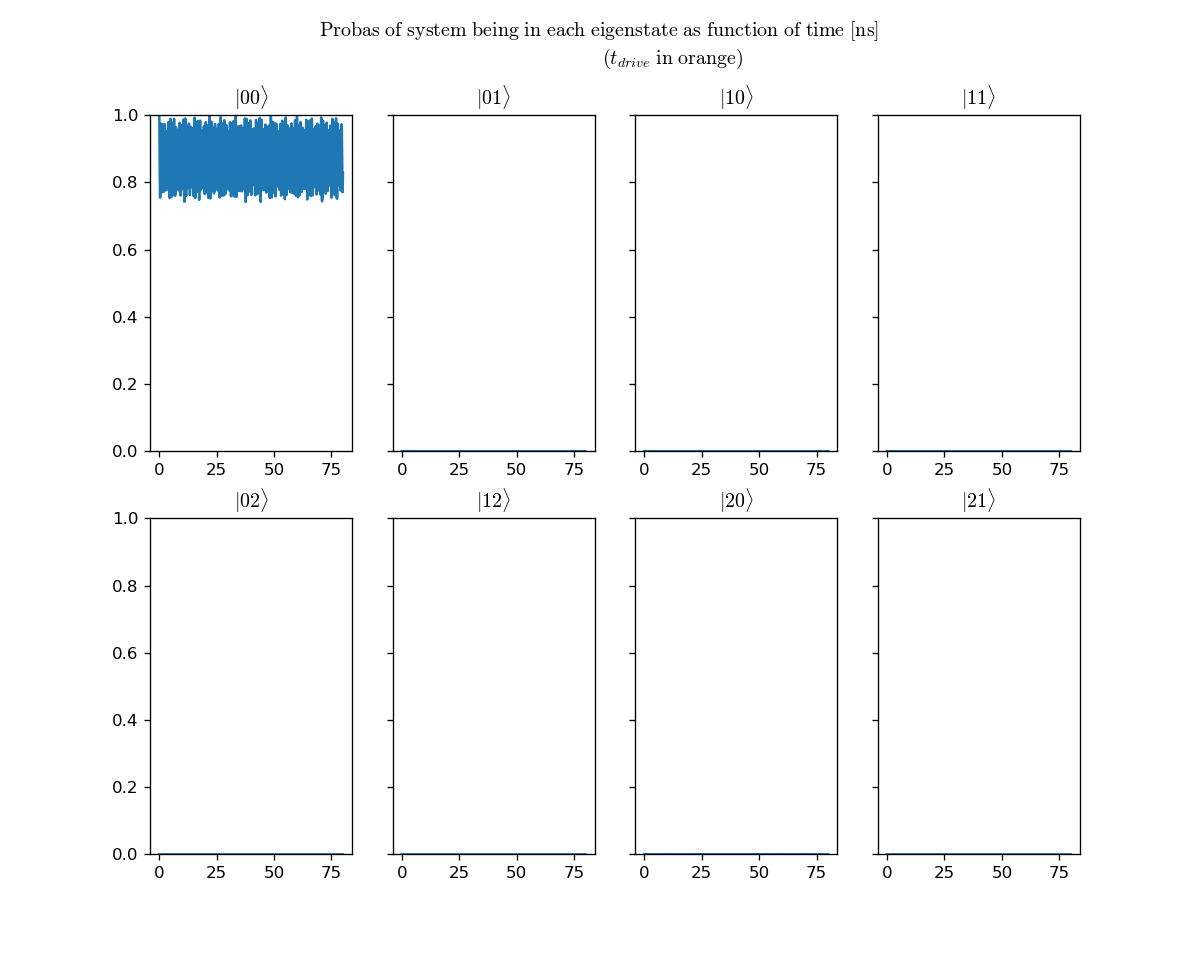

In [11]:
_ = test_simu(jc = 0.225, 
              eta = [1, 0],
              list_init = [0], 
              freq_drive = None,
              tps_simu = 2* 40 * 2*np.pi,
              plot_spectrum = False,
              plot_proba = True, 
              plot_phase = False, 
              plot_proj = False)

## Leakage

In [ ]:
def leakage(state_init, 
            tlist=tlist, hamil0=hamil0, hamil_drive=hamil_drive, pulse_drive=pulse_drive, 
            bool_plot = True):
    result = solvkit.integrate(tlist, state_init, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
    
    probs = np.zeros([4, t_points], dtype=float)
    for k in range(0, t_points):
        probs[0, k] = qtp.expect(rho_00, result.states[k]) 
        probs[1, k] = qtp.expect(rho_01, result.states[k]) 
        probs[2, k] = qtp.expect(rho_10, result.states[k]) 
        probs[3, k] = qtp.expect(rho_11, result.states[k]) 
    
    leakage = [1-sum(probs[:,j]) for j in range(len(tlist))]
    if bool_plot:
        plt.figure()
        plt.plot(tlist/(2*np.pi), leakage)
        plt.plot([t_drive, t_drive], [0, 1], label = "$t_{drive}$")
        plt.xlabel('time')
        plt.ylabel('leakage')
        plt.legend()
        
    
    print("Max leakage over this time period is : "+ str(np.max(leakage)*100) + "%")
    
state_init = state00#state00 + state_01 + state_10 + state_11
leakage(state_init)

In [ ]:
print("\nFor only state00:")
leakage(state00, bool_plot = False)

print("\nFor only state01:")
leakage(state01, bool_plot = False)

print("\nFor only state10:")
leakage(state10, bool_plot = False)

print("\nFor only state11:")
leakage(state11, bool_plot = False)

# Tomography

In [ ]:
def gate_function(state_in, **kwargs):
    t_points = kwargs['t_points']
    tlist = np.linspace(0, kwargs['t_max'], t_points)
    rho_in = state_in*state_in.dag()
    hamil0 = kwargs['hamil0']
    hamil_drive = kwargs['hamil_drive']
                                  
    pulse_drive = np.cos(kwargs['freq_drive']*tlist)

    result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

    end_state = result.states[-1]
    return end_state

In [ ]:
param_dict = {
    't_points' : 10000 ,
    't_max' : t_drive,
    'hamil0' : coupled_flx.hamiltonian(as_qobj=True),
    'hamil_drive' : qtp.Qobj(inpt=eta[0]*n_charge[0] + eta[1]*n_charge[1], 
                       dims=hamil0.dims, shape=hamil0.shape, isherm=True),
    'freq_drive' : freq_drive
}

In [ ]:
import pysqkit.tomography.utilsTomo as tomo

In [ ]:
fct = tomo.rid_of_dict(gate_function,param_dict)
nb_levels = [3,3]

In [ ]:
deb =  time.time()
lambda_mat = tomo.fct_to_lambda(fct, nb_levels, draw_lambda = True)
print("It took" , time.time() - deb, "seconds")

In [ ]:
deb =  time.time()
chi_mat = tomo.lambda_to_chi(lambda_mat, nb_levels, draw_chi = True )
print("It took" , time.time() - deb, "seconds")

In [ ]:
lambda_mat_2lev = np.zeros((16, 16))*1j

for i in range(16):
    for j in range(16):
        ani, bni, ami, bmi = tomo._n_th([2, 2, 2, 2], i) #i is |ani bni><ami bmi|
        anj, bnj, amj, bmj = tomo._n_th([2, 2, 2, 2], j)
        
        lambda_mat_2lev[i,j] = lambda_mat[ani*27 + bni * 9 + ami * 3 + bmi][anj*27 + bnj * 9 + amj* 3 + bmj]

In [ ]:
tomo.draw_mat(lambda_mat_2lev, "\lambda^2")

In [ ]:
chi_mat_2lev = tomo.lambda_to_chi(lambda_mat_2lev, [2,2], draw_chi = True)

chi_CZ = np.zeros((16,16))
chi_CZ[0,0] = 1
chi_CZ[0,3] = 1
chi_CZ[3,0] = 1
chi_CZ[3,3] = 1

chi_CZ[0,12] = 1
chi_CZ[3,12] = 1
chi_CZ[0,15] = -1
chi_CZ[3,15] = -1

chi_CZ[12,12] = 1
chi_CZ[15,12] = -1
chi_CZ[12,15] = -1
chi_CZ[15,15] = 1

chi_CZ[12,0] = 1
chi_CZ[12,3] = 1
chi_CZ[15,0] = -1
chi_CZ[15,3] = -1

tomo.draw_mat(chi_CZ, "\chi^{CZ}")